# Ecommerce Analysis with Python and SQLite

This notebook analyzes Brazilian eCommerce data using Python and SQLite. We load CSV files, store them into SQLite, and perform insightful analytics and visualizations.

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style='whitegrid')
%matplotlib inline

In [2]:
conn = sqlite3.connect("ecommerce.db")
cursor = conn.cursor()

In [3]:
csv_folder = r"C:\Users\User\ecommerce-analysis\data" 

csv_files = [
    "customers.csv", "order_items.csv", "orders.csv", "payments.csv",
    "geolocation.csv", "products.csv", "sellers.csv"
]

for file in csv_files:
    table_name = file.replace(".csv", "")
    df = pd.read_csv(os.path.join(csv_folder, file))
    df.to_sql(table_name, conn, if_exists="replace", index=False)
    print(f"Loaded: {table_name}")

Loaded: customers
Loaded: order_items
Loaded: orders
Loaded: payments
Loaded: geolocation
Loaded: products
Loaded: sellers


## Number of Orders by Status

Number of Orders by Status:
order_status  count
   delivered  96478
     shipped   1107
    canceled    625
 unavailable    609
    invoiced    314
  processing    301
     created      5
    approved      2


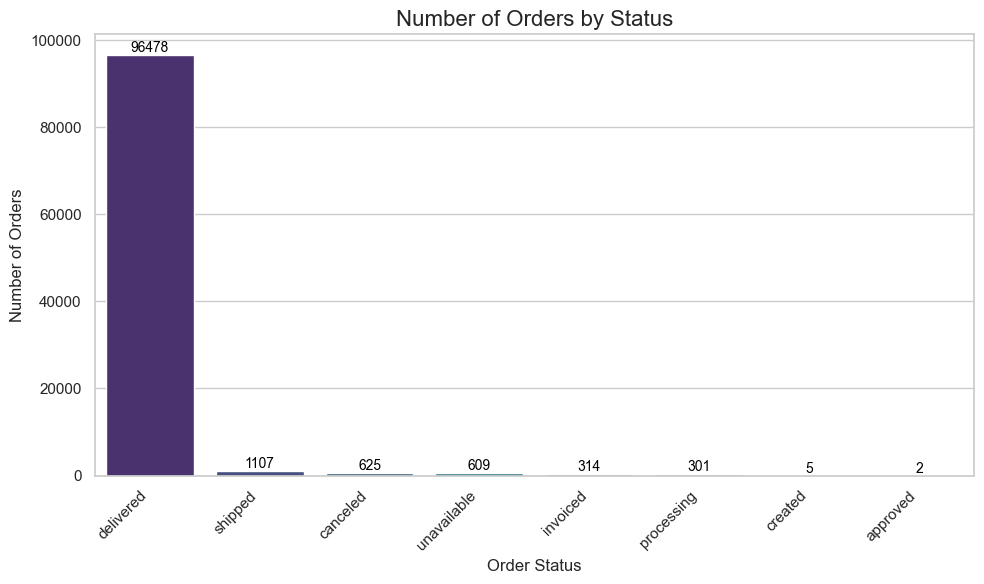

In [4]:
query1 = """
    SELECT order_status, COUNT(*) as count
    FROM orders
    GROUP BY order_status
    ORDER BY count DESC
"""
df1 = pd.read_sql(query1, conn)
print("Number of Orders by Status:")
print(df1.to_string(index=False))

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df1, x='order_status', y='count', palette='viridis', hue='order_status', legend=False)
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', fontsize=10, color='black')
plt.title("Number of Orders by Status", fontsize=16)
plt.ylabel("Number of Orders", fontsize=12)
plt.xlabel("Order Status", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Orders Over Time (Monthly)

Data (first 5 rows):
     month  order_count
0  2016-09            1
1  2016-10          265
2  2016-12            1
3  2017-01          750
4  2017-02         1653


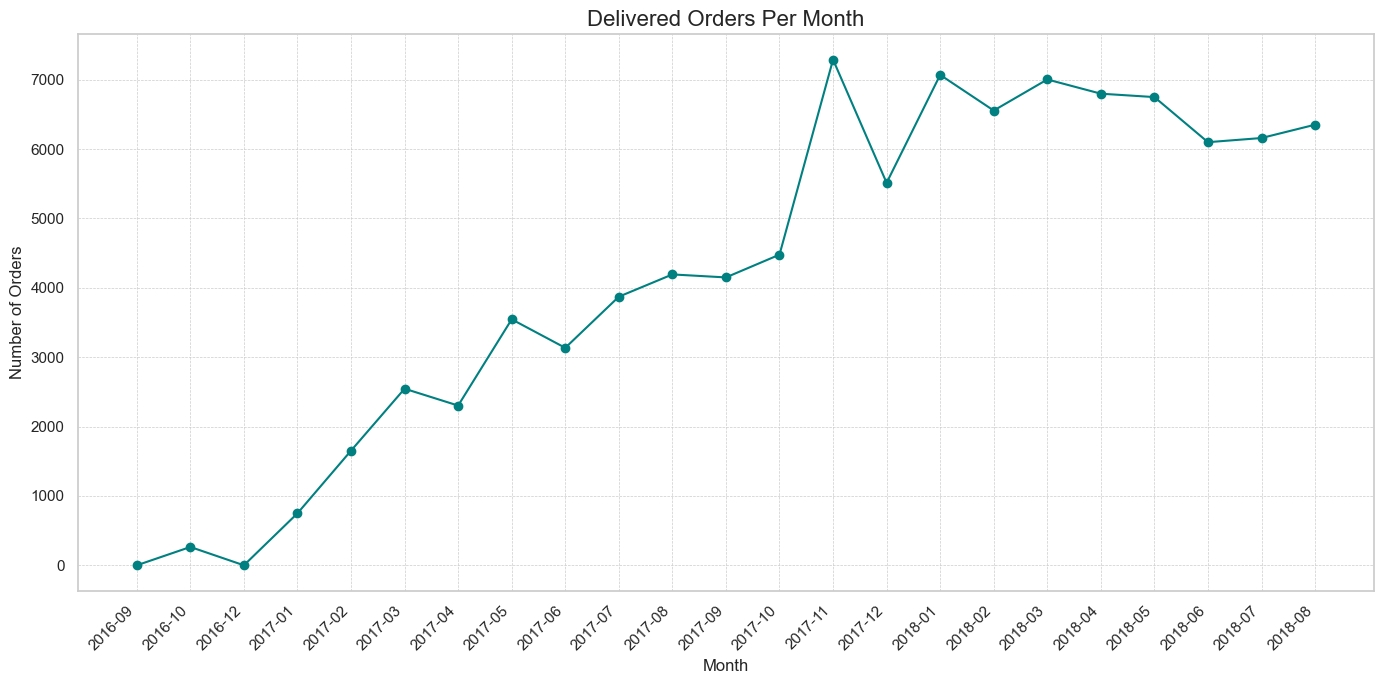

In [5]:
query2 = """
    SELECT strftime('%Y-%m', order_purchase_timestamp) as month, COUNT(*) as order_count
    FROM orders
    WHERE order_status = 'delivered'
    GROUP BY month
    ORDER BY month
"""
df2 = pd.read_sql(query2, conn)
print("Data (first 5 rows):")
print(df2.head())

plt.figure(figsize=(14, 7))
plt.plot(df2['month'], df2['order_count'], marker='o', linestyle='-', color='teal')
plt.title("Delivered Orders Per Month", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of Orders", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

## Revenue Over Time

Data (first 5 rows):
     month  total_revenue
0  2016-10       46566.71
1  2016-12          19.62
2  2017-01      127545.67
3  2017-02      271298.65
4  2017-03      414369.39


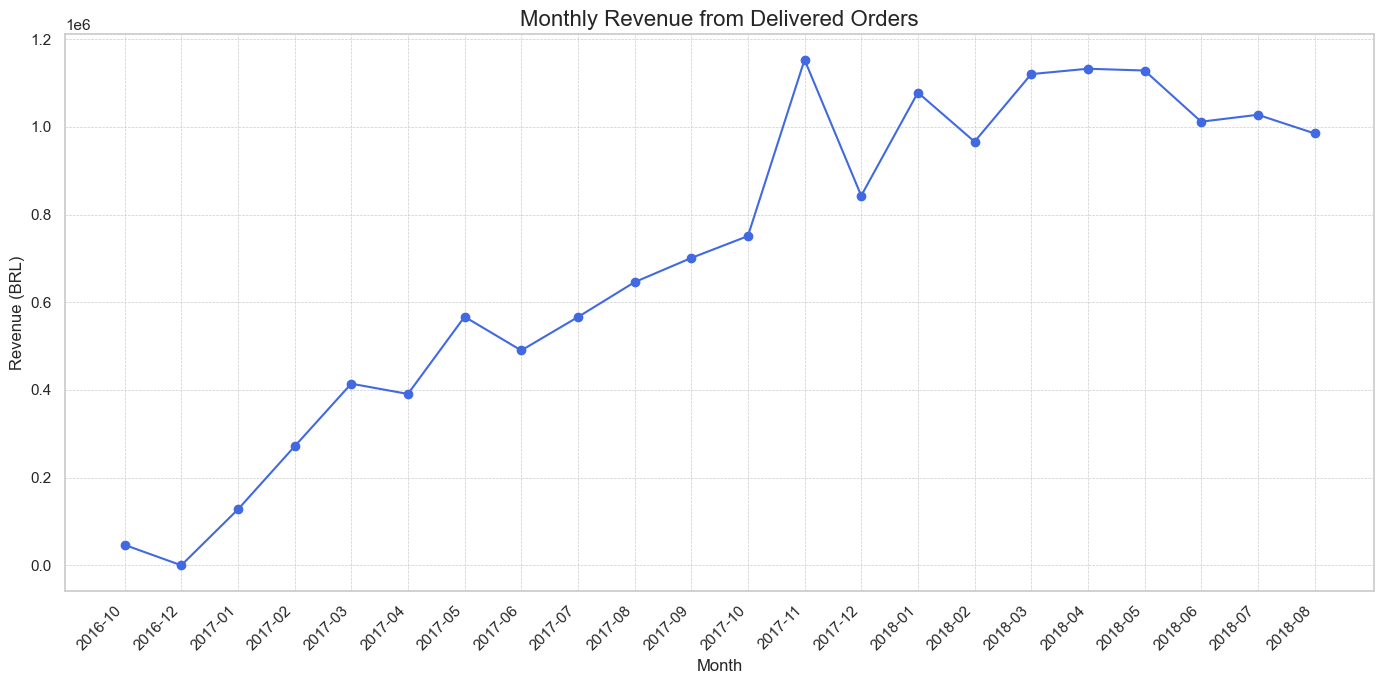

In [6]:
query3 = """
    SELECT strftime('%Y-%m', o.order_purchase_timestamp) AS month,
           ROUND(SUM(p.payment_value), 2) AS total_revenue
    FROM orders o
    JOIN payments p ON o.order_id = p.order_id
    WHERE o.order_status = 'delivered'
    GROUP BY month
    ORDER BY month
"""
df3 = pd.read_sql(query3, conn)
print("Data (first 5 rows):")
print(df3.head())

plt.figure(figsize=(14, 7))
plt.plot(df3['month'], df3['total_revenue'], marker='o', linestyle='-', color='royalblue')
plt.title('Monthly Revenue from Delivered Orders', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Revenue (BRL)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

## Top 10 Best-Selling Products

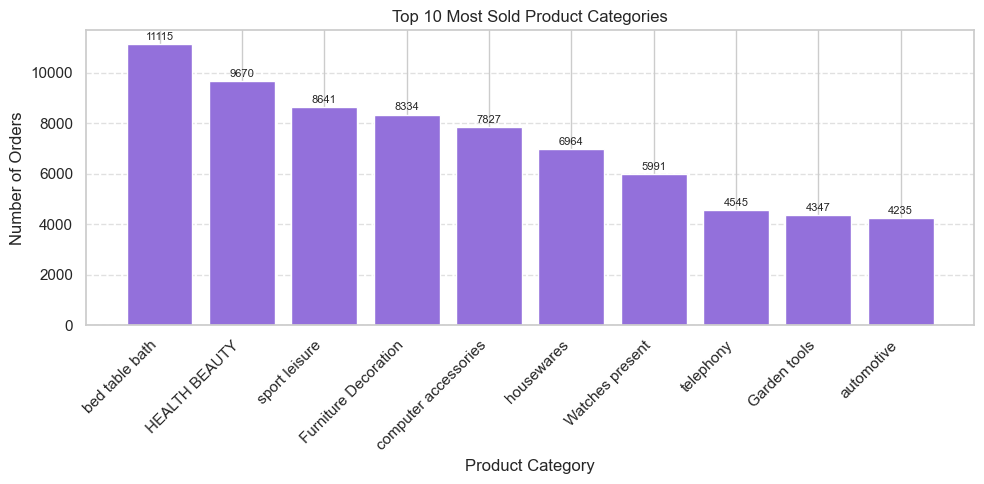

In [7]:
query4 = """
    SELECT p."product category" AS category, COUNT(*) AS total_sold
    FROM order_items oi
    JOIN products p ON oi.product_id = p.product_id
    WHERE p."product category" IS NOT NULL
    GROUP BY p."product category"
    ORDER BY total_sold DESC
    LIMIT 10
"""
df4 = pd.read_sql(query4, conn)

plt.figure(figsize=(10, 5))
bars = plt.bar(df4['category'], df4['total_sold'], color='mediumpurple')
plt.title('Top 10 Most Sold Product Categories')
plt.xlabel('Product Category')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45, ha='right')
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', fontsize=8)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

## Average Freight Value

In [8]:
query5 = "SELECT AVG(freight_value) as avg_freight FROM order_items"
df5 = pd.read_sql(query5, conn)
avg_freight = df5['avg_freight'].iloc[0]
print(f"Average freight value: {avg_freight:.2f} BRL")

Average freight value: 19.99 BRL


## Payment Type Frequency

Data:
  payment_type  count
0  credit_card  76795
1          UPI  19784
2      voucher   5775
3   debit_card   1529
4  not_defined      3


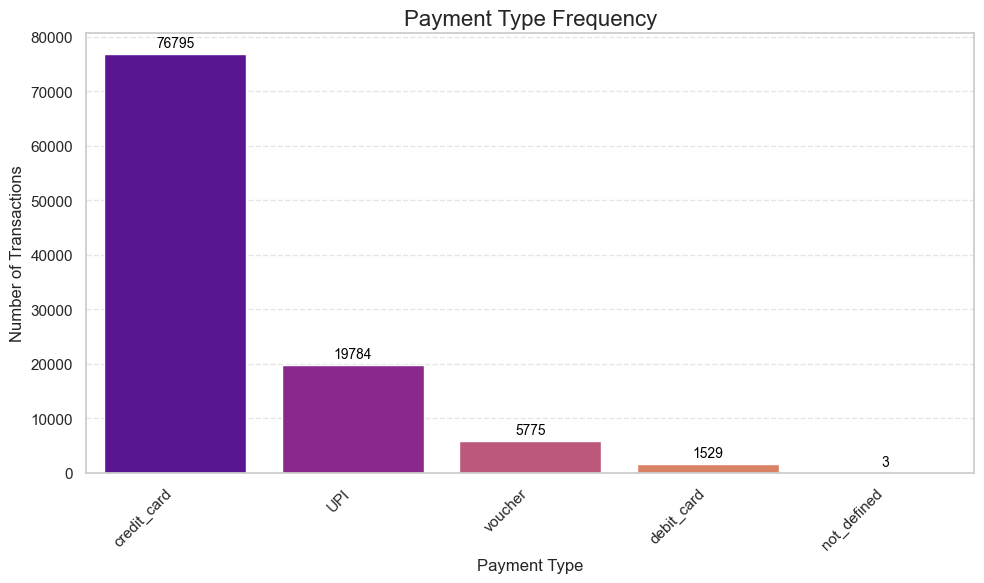

In [9]:
query6 = """
    SELECT payment_type, COUNT(*) as count
    FROM payments
    GROUP BY payment_type
    ORDER BY count DESC
"""
df6 = pd.read_sql(query6, conn)
print("Data:")
print(df6)

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df6, x='payment_type', y='count', hue='payment_type', palette='plasma', legend=False)
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', fontsize=10, color='black', padding=3)
plt.title("Payment Type Frequency", fontsize=16)
plt.xlabel("Payment Type", fontsize=12)
plt.ylabel("Number of Transactions", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

## Geographic Distribution of Orders

Data:
   state  customer_count
0     SP           40302
1     RJ           12384
2     MG           11259
3     RS            5277
4     PR            4882
5     SC            3534
6     BA            3277
7     DF            2075
8     ES            1964
9     GO            1952
10    PE            1609
11    CE            1313
12    PA             949
13    MT             876
14    MA             726


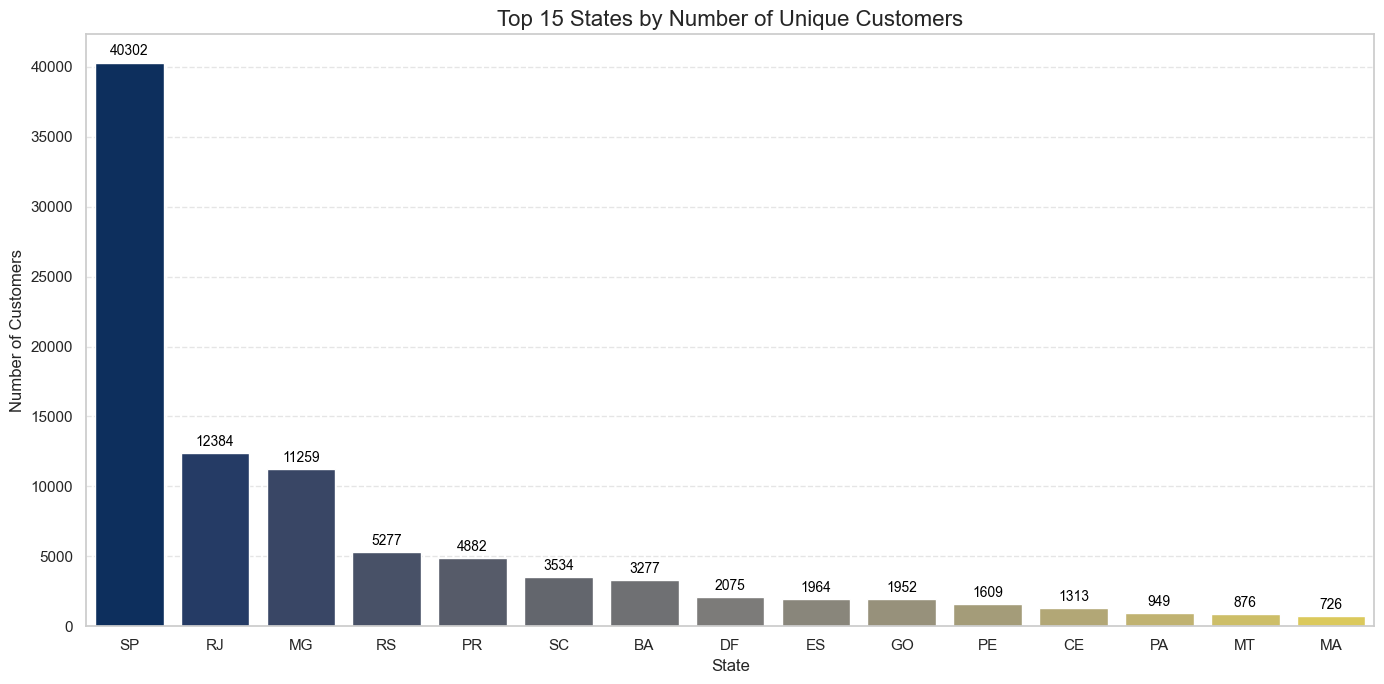

In [10]:
query7 = """
    SELECT customer_state as state, COUNT(DISTINCT customer_unique_id) as customer_count
    FROM customers
    GROUP BY customer_state
    ORDER BY customer_count DESC
    LIMIT 15
"""
df7 = pd.read_sql(query7, conn)
print("Data:")
print(df7)

plt.figure(figsize=(14, 7))
ax = sns.barplot(data=df7, x='state', y='customer_count', hue='state', palette='cividis', legend=False)
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', fontsize=10, color='black', padding=3)
plt.title("Top 15 States by Number of Unique Customers", fontsize=16)
plt.xlabel("State", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

## Number of Unique Customers and Sellers

In [11]:
query8 = "SELECT COUNT(DISTINCT customer_id) as unique_customers FROM customers"
df8 = pd.read_sql(query8, conn)
print(f"Unique customers: {df8['unique_customers'].iloc[0]}")

query8 = "SELECT COUNT(DISTINCT seller_id) as unique_sellers FROM sellers"
df8 = pd.read_sql(query8, conn)
print(f"Unique sellers: {df8['unique_sellers'].iloc[0]}")

Unique customers: 99441
Unique sellers: 3095


##  Average Delivery Time by Region

Data:
   customer_state  avg_delivery_days
0              RR          29.387546
1              AP          27.185068
2              AM          26.425991
3              AL          24.543855
4              PA          23.772917
5              MA          21.572976
6              SE          21.519788
7              CE          21.266579
8              AC          21.035713
9              PB          20.426768
10             PI          19.457098
11             RO          19.372037
12             BA          19.335466
13             RN          19.278156
14             PE          18.448323


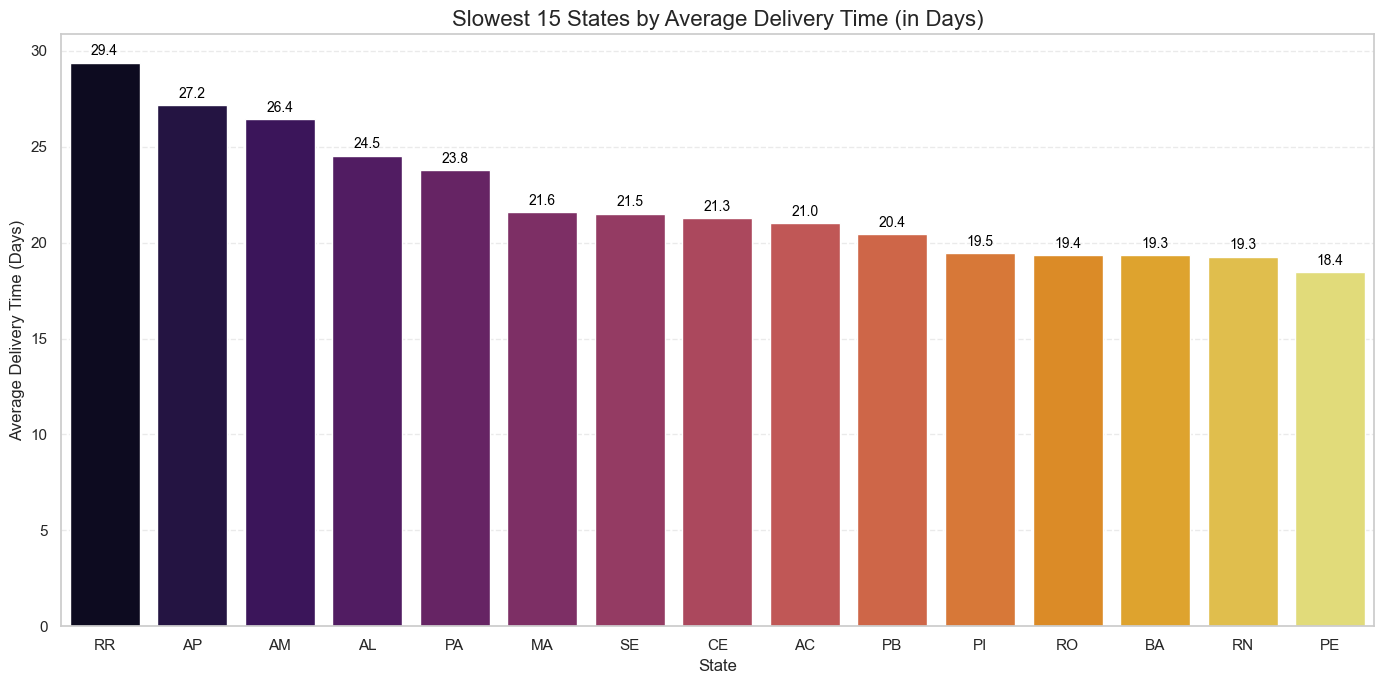

In [12]:
query9 = """
    SELECT c.customer_state,
           AVG(julianday(o.order_delivered_customer_date) - julianday(o.order_purchase_timestamp)) as avg_delivery_days
    FROM orders o
    JOIN customers c ON o.customer_id = c.customer_id
    WHERE o.order_status = 'delivered' AND o.order_delivered_customer_date IS NOT NULL
    GROUP BY c.customer_state
    ORDER BY avg_delivery_days DESC
    LIMIT 15
"""
df9 = pd.read_sql(query9, conn)
print("Data:")
print(df9)

plt.figure(figsize=(14, 7))
ax = sns.barplot(data=df9, x='customer_state', y='avg_delivery_days', hue='customer_state', palette='inferno', legend=False)
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', fontsize=10, color='black', padding=3)
plt.title("Slowest 15 States by Average Delivery Time (in Days)", fontsize=16)
plt.xlabel("State", fontsize=12)
plt.ylabel("Average Delivery Time (Days)", fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

## Products with Highest Markup

In [13]:
query10 = """
    SELECT product_id, MAX(price - freight_value) AS markup
    FROM order_items
    GROUP BY product_id
    ORDER BY markup DESC
    LIMIT 10
"""
df10 = pd.read_sql(query10, conn)
print(df10)

                         product_id   markup
0  489ae2aa008f021502940f251d4cce7f  6540.69
1  69c590f7ffc7bf8db97190b6cb6ed62e  6535.79
2  1bdf5e6731585cf01aa8169c7028d6ad  6271.34
3  a6492cc69376c469ab6f61d8f44de961  4647.66
4  c3ed642d592594bb648ff4a04cee2747  4615.66
5  259037a6a41845e455183f89c5035f18  4498.22
6  a1beef8f3992dbd4cd8726796aa69c53  4286.42
7  6cdf8fc1d741c76586d8b6b15e9eef30  4024.72
8  6902c1962dd19d540807d0ab8fade5c6  3982.89
9  dd113cb02b2af9c8e5787e8f1f0722f6  3954.49


## Top 10 Customers by Order Value

In [14]:
query11 = """
    SELECT c.customer_unique_id,
           ROUND(SUM(p.payment_value), 2) AS total_spent
    FROM orders o
    JOIN payments p ON o.order_id = p.order_id
    JOIN customers c on o.customer_id = c.customer_id
    WHERE o.order_status = 'delivered'
    GROUP BY c.customer_unique_id
    ORDER BY total_spent DESC
    LIMIT 10
"""
df11 = pd.read_sql(query11, conn)
print("Data:")
print(df11)

Data:
                 customer_unique_id  total_spent
0  0a0a92112bd4c708ca5fde585afaa872     13664.08
1  da122df9eeddfedc1dc1f5349a1a690c      7571.63
2  763c8b1c9c68a0229c42c9fc6f662b93      7274.88
3  dc4802a71eae9be1dd28f5d788ceb526      6929.31
4  459bef486812aa25204be022145caa62      6922.21
5  ff4159b92c40ebe40454e3e6a7c35ed6      6726.66
6  4007669dec559734d6f53e029e360987      6081.54
7  eebb5dda148d3893cdaf5b5ca3040ccb      4764.34
8  48e1ac109decbb87765a3eade6854098      4681.78
9  c8460e4251689ba205045f3ea17884a1      4655.91


## Cancelled & Other Non-Delivered Orders

Data:
                 customer_unique_id  total_spent
0  0a0a92112bd4c708ca5fde585afaa872     13664.08
1  da122df9eeddfedc1dc1f5349a1a690c      7571.63
2  763c8b1c9c68a0229c42c9fc6f662b93      7274.88
3  dc4802a71eae9be1dd28f5d788ceb526      6929.31
4  459bef486812aa25204be022145caa62      6922.21
5  ff4159b92c40ebe40454e3e6a7c35ed6      6726.66
6  4007669dec559734d6f53e029e360987      6081.54
7  eebb5dda148d3893cdaf5b5ca3040ccb      4764.34
8  48e1ac109decbb87765a3eade6854098      4681.78
9  c8460e4251689ba205045f3ea17884a1      4655.91


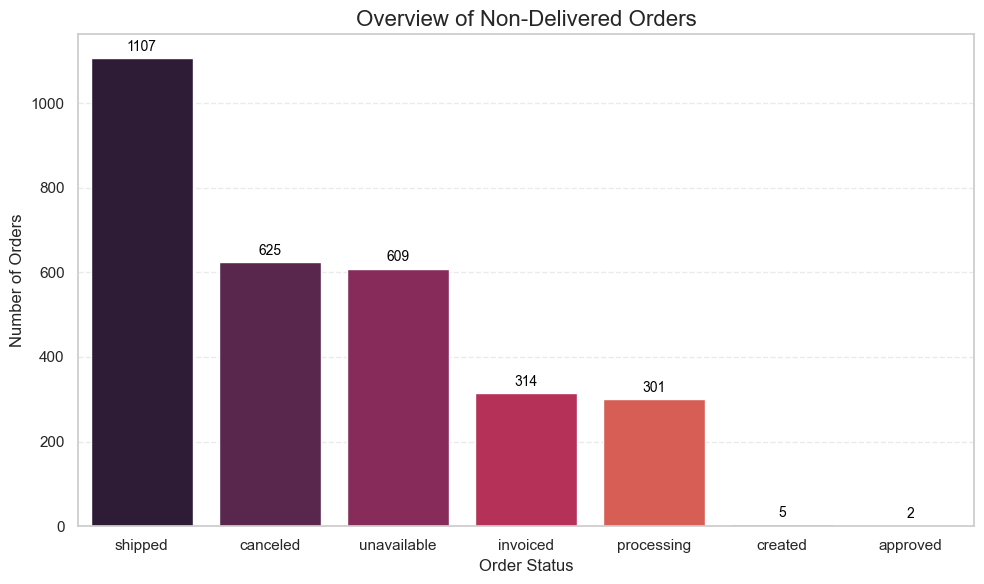

In [15]:
query12 = """
    SELECT order_status, COUNT(*) AS count
    FROM orders
    WHERE order_status != 'delivered'
    GROUP BY order_status
    ORDER BY count DESC
"""
df12 = pd.read_sql(query12, conn)
print("Data:")
print(df11)

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df12,x='order_status',y='count',hue='order_status',palette='rocket',legend=False)
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', fontsize=10, color='black', padding=3)

plt.title("Overview of Non-Delivered Orders", fontsize=16)
plt.xlabel("Order Status", fontsize=12)
plt.ylabel("Number of Orders", fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

## Category Seasonality

Delivered Orders per Month and Product Category:
month                                 product_category  order_count
   01                                             None          205
   01                        Agro Industria e Comercio           21
   01                                              Art           19
   01                                 Bags Accessories          131
   01                                     Blu Ray DVDs            4
   01                       CITTE AND UPHACK FURNITURE            9
   01                      CONSTRUCTION SECURITY TOOLS           11
   01                                  Casa Construcao           40
   01                               Christmas articles           10
   01                  Construction Tools Construction           48
   01                        Construction Tools Garden           24
   01                  Construction Tools Illumination            7
   01                         Construction Tools Tools            8

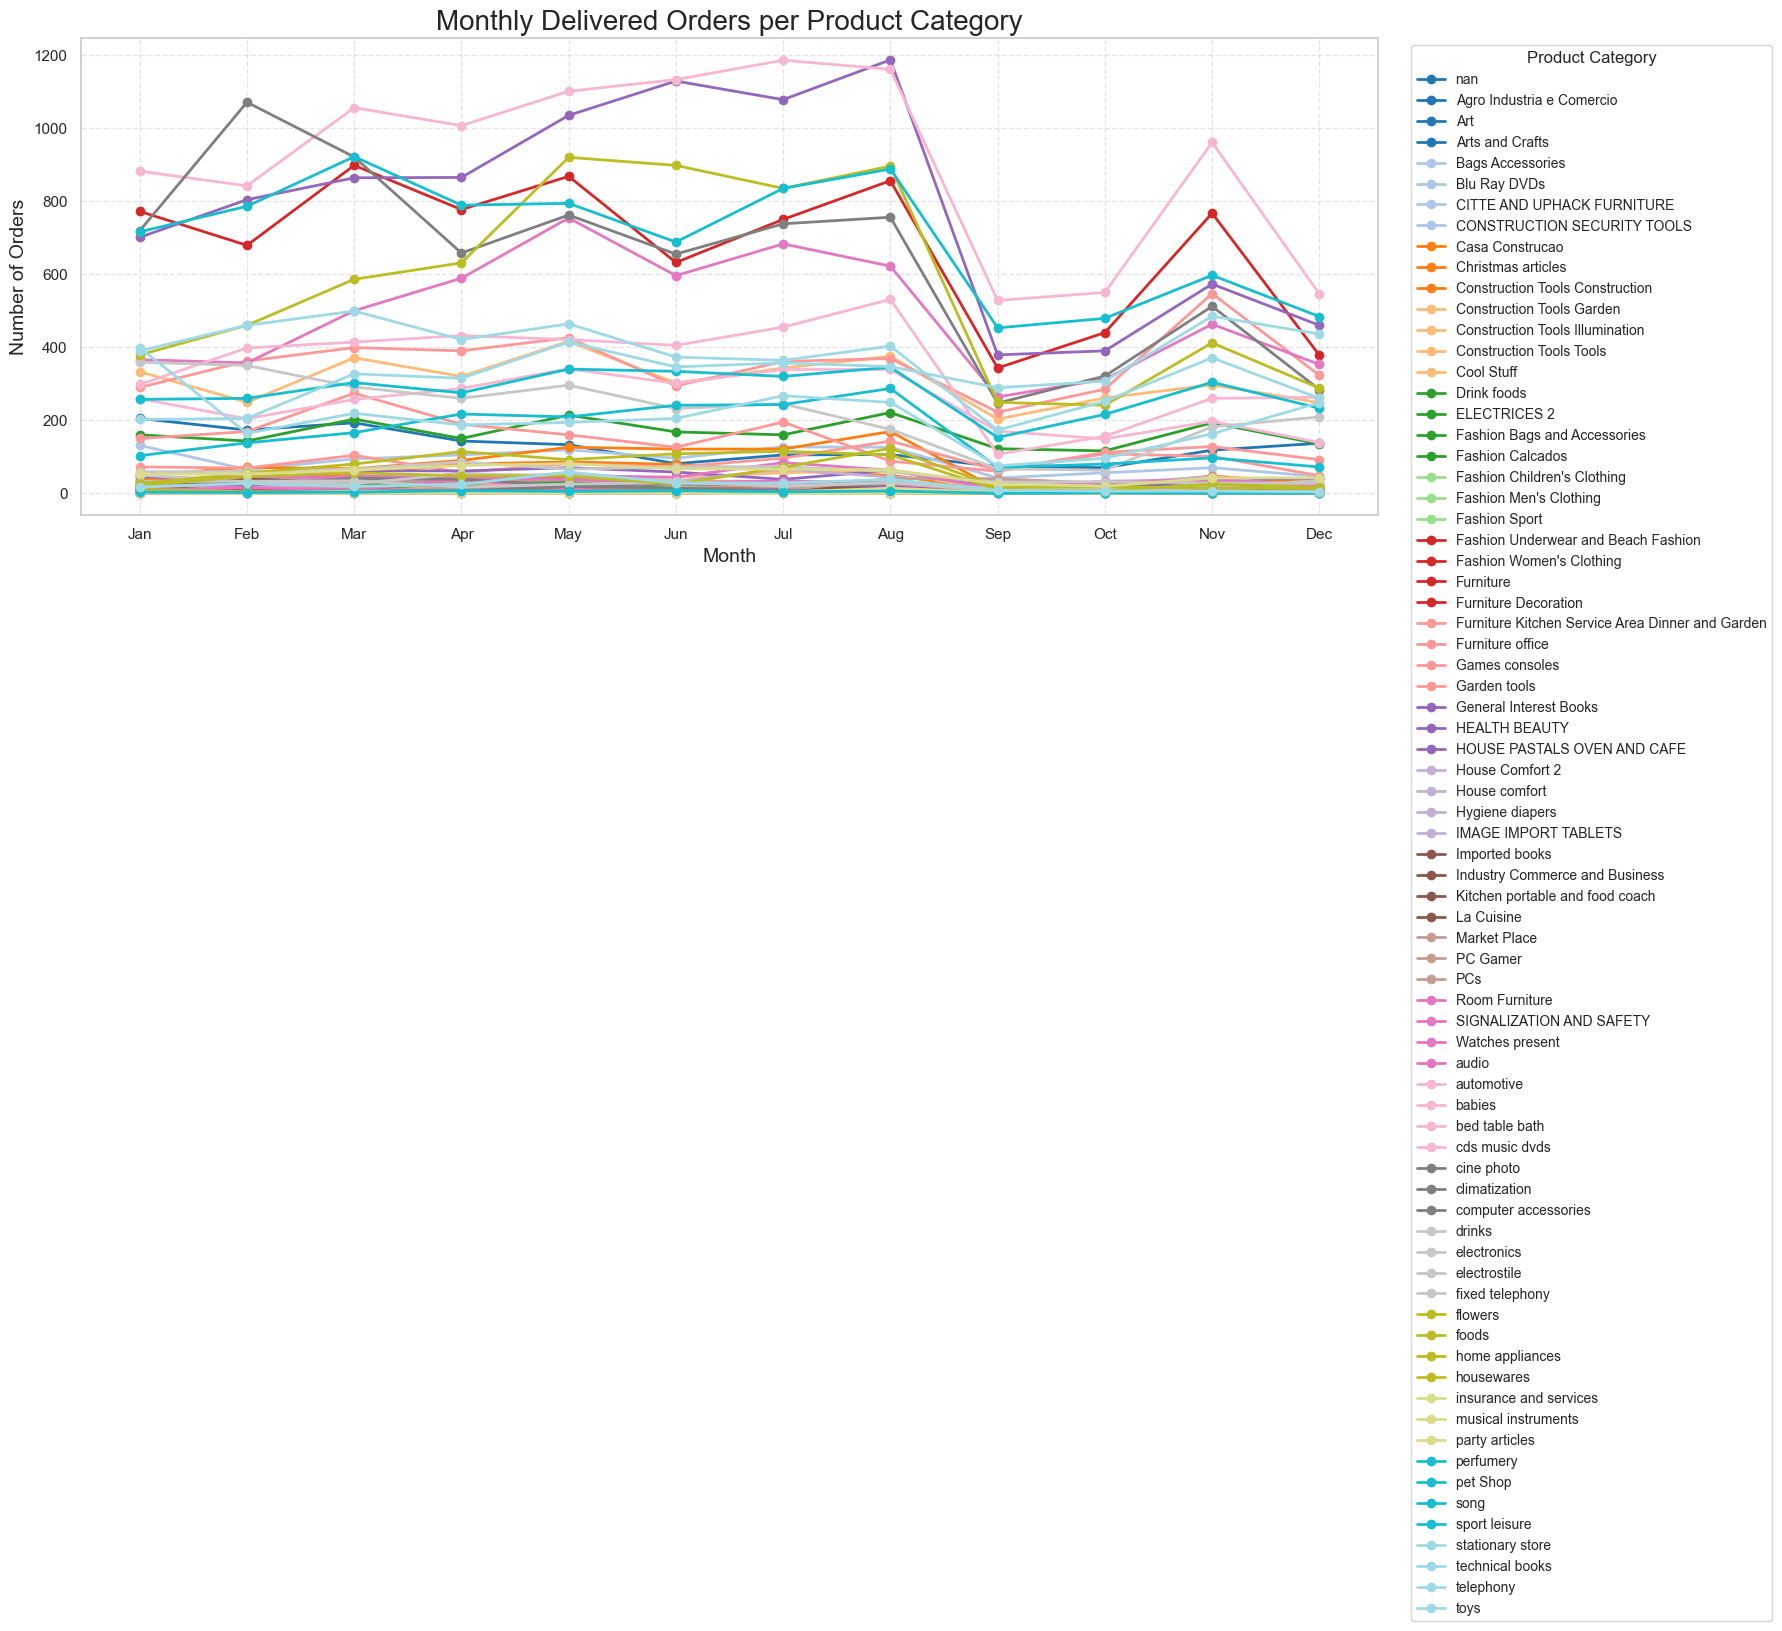

In [16]:
query13 = """
    SELECT 
        strftime('%m', o.order_purchase_timestamp) AS month,
        p."product category" AS product_category,
        COUNT(*) AS order_count
    FROM orders o
    JOIN order_items oi ON o.order_id = oi.order_id
    JOIN products p ON oi.product_id = p.product_id
    WHERE o.order_status = 'delivered'
    GROUP BY month, product_category
"""
df13 = pd.read_sql(query13, conn)
print("Delivered Orders per Month and Product Category:")
print(df13.to_string(index=False))
pivot13 = df13.pivot(index='month', columns='product_category', values='order_count').fillna(0)
pivot13.index.name = 'Month'

fig, ax = plt.subplots(figsize=(18, 12))
pivot13.plot(kind='line', marker='o', linewidth=2, ax=ax, cmap='tab20')
ax.set_title("Monthly Delivered Orders per Product Category", fontsize=20)
ax.set_xlabel("Month", fontsize=14)
ax.set_ylabel("Number of Orders", fontsize=14)
ax.set_xticks(range(0, 12))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(title='Product Category', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

## Purchase to Delivery Time Distribution

Columns in df14: Index(['delivery_time'], dtype='object')
Summary Statistics for Delivery Time (Days):
count    96470.000000
mean        12.558217
std          9.546156
min          0.533414
25%          6.766204
50%         10.217477
75%         15.720182
max        209.628611
Name: delivery_time, dtype: float64


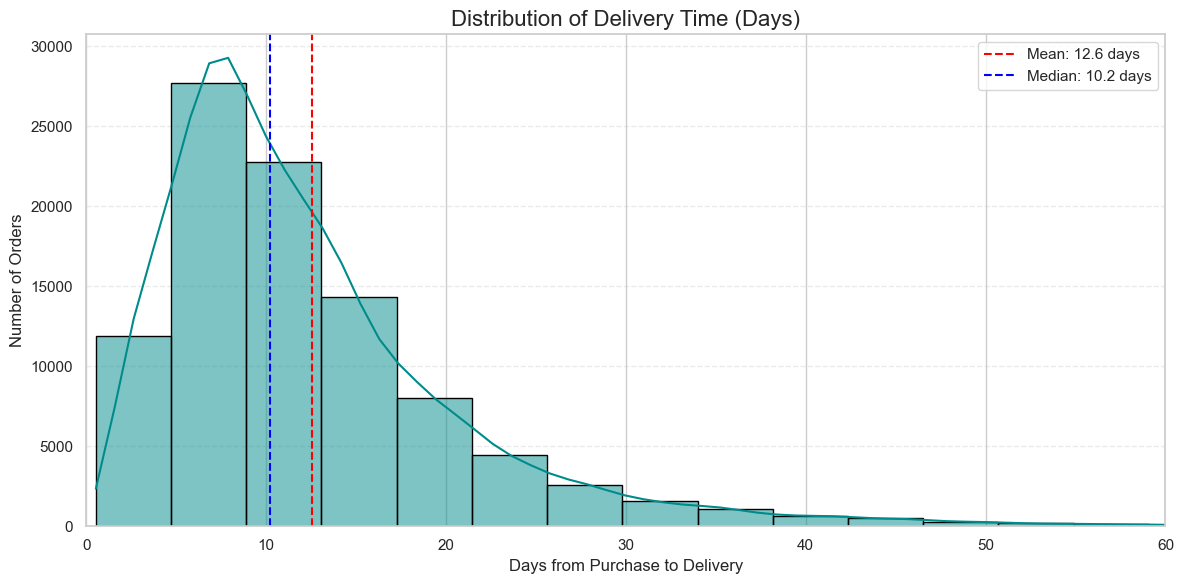

In [17]:
query14 = """
    SELECT 
        julianday(order_delivered_customer_date) - julianday(order_purchase_timestamp) AS delivery_time
    FROM orders
    WHERE 
        order_status = 'delivered' 
        AND order_delivered_customer_date IS NOT NULL
        AND order_purchase_timestamp IS NOT NULL
        AND (julianday(order_delivered_customer_date) - julianday(order_purchase_timestamp)) > 0
"""
df14 = pd.read_sql(query14, conn)
print("Columns in df14:", df14.columns)

print("Summary Statistics for Delivery Time (Days):")
print(df14['delivery_time'].describe())

plt.figure(figsize=(12, 6))
ax = sns.histplot(df14['delivery_time'],bins=50,kde=True,color='darkcyan',edgecolor='black')

mean_val = df14['delivery_time'].mean()
median_val = df14['delivery_time'].median()
plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.1f} days')
plt.axvline(median_val, color='blue', linestyle='--', label=f'Median: {median_val:.1f} days')

plt.title("Distribution of Delivery Time (Days)", fontsize=16)
plt.xlabel("Days from Purchase to Delivery", fontsize=12)
plt.ylabel("Number of Orders", fontsize=12)
plt.xlim(0, 60)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [18]:
conn.close()